## Gurpreet Singh

### IS 602:  Advanced Programming Techniques

## <font color='red'>  NEW YORK CITY Crime Hotspot Prediction and Analysis of Crime Data</font> </h3> 

### Sections

*  [Abstract](#Abstract)


*  [Required Libraries](#Installing the required libraries)


*  [Data Collection](#Data Collection and Manipulation)


*  [Data Analysis](#Data Analysis)
    * [Chi-square test of Independence](#Chi-square)
    * [Correlation](#Correlation)
    * [Splitting into crime zones](#zones)


*  [Predictive Analysis](#Predictive Analysis)

    * [Splitting the Dataset into training and testing](#Split Data)
    
    * [Fitting the Random Forest Model](#RFR)
    
    * [Predictied Dataset](#Pred Data)
    
    * [Reverse Lookup of Locations](#Lookup)
    


*  [Data Visualization](#Data Visualization)


*  [Conclusion](#Conclusion)


*  [Further Reading and Analysis](#Further Reading)


*  [Refrences](#Refrences)



# Abstract: 
Analysis of crime data in predicting crime hotspots is successfully established and implemented in various police departments all over the world. Continuation of crime data collection,  hotspot monitoring allows for advancement and improvement in data collection methods and enhancing the algorithms provides improvement and accuracy in existing algorithms. Algorithms are needed to be updated continuously as more and more data become available.Crime hotspots depicts valuable information to the extent that criminals repeatedly using same modus operandi for committing crimes, or they are involved in a particular crime in the area of high crime risk for a specific crime

### Installing the required libraries<a id='Installing the required libraries'></a>

In [1]:
import csv
import sys
import urllib
import numpy as np
import pandas as pd
import scipy
import math
import scipy.stats
import datetime
import random
import matplotlib
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import matplotlib.lines as ml
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

sys.path.append('C:\\Python27\\lib\\site-packages')
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from IPython.display import HTML, display



# Data Collection and Manipulation:<a id='Data Collection and Manipulation'></a>

Data collection is performed using open data source data.gov.The dataset consists of quarterly update of  Major Felonies 
at the incident level.The felonies included are Burglary, Grand Larceny, Rape,Grand Larceny of Motor Vehicles, Robbery, 
Felony Assault.The data is recorded in CompStat (short for Computer Statistics). Detailed Information about CompStat can be
found [here](https://en.wikipedia.org/wiki/CompStat). We will drop the fields CompStat Day, month and year from our dataset.
The location coordinates of the incident are tracked and recorded in database. Location will be splitted into Longitudes and latitudes for prediction.
Crimes are separated by boroughs, sectors,further into precincts in New York City. Occurrence date in the dataset is 
converted into timestamp.
Additional information about the data can be found [here](https://catalog.data.gov/dataset/nypd-7-major-felony-incidents)


In [3]:
df =pd.read_csv('C:\\Users\\Gurpreet\\Documents\\IS602\\historical_crimedata.csv')


#### Structure of the dataset

In [4]:
df.shape

(1048575, 17)

In [5]:
df = df.dropna(axis=0,how='any',inplace=False) #cleaning the data by removing nan values
df=df.query('Borough != "(null)"')

split_data = df["Location 1"].str.strip(')').str.strip('(').str.split(', ') 
# splitting Location variable into latitudes and longitudes
df['Latitude'] = split_data.apply(lambda x: x[0])
df['Longitude'] = split_data.apply(lambda x: x[1])
df['Latitude'] =df['Latitude'].astype(float)
df['Longitude'] =df['Longitude'].astype(float)


In [6]:
df.head()

,OBJECTID,Occurrence Date,Day of Week,Occurrence Month,Occurrence Day,Occurrence Year,Occurrence Hour,CompStat Month,CompStat Day,CompStat Year,Offense,Sector,Precinct,Borough,XCoordinate,YCoordinate,Location 1,Latitude,Longitude
0,1,9/6/1940 19:30,Friday,Sep,6.0,1940.0,19.0,9,7,2010,BURGLARY,D,66.0,BROOKLYN,987478,166141,"(40.6227027620001, -73.9883732929999)",40.622703,-73.988373
1,2,12/14/1968 0:20,Saturday,Dec,14.0,1968.0,0.0,12,14,2008,GRAND LARCENY,G,28.0,MANHATTAN,996470,232106,"(40.8037530600001, -73.955861904)",40.803753,-73.955862
2,3,10/30/1970 15:30,Friday,Oct,30.0,1970.0,15.0,10,31,2008,BURGLARY,H,84.0,BROOKLYN,986508,190249,"(40.688874254, -73.9918594329999)",40.688874,-73.991859
3,4,7/18/1972 23:00,Tuesday,Jul,18.0,1972.0,23.0,7,19,2012,GRAND LARCENY OF MOTOR VEHICLE,F,73.0,BROOKLYN,1005876,182440,"(40.6674141890001, -73.9220463899999)",40.667414,-73.922046
4,5,5/21/1987 0:01,Thursday,May,21.0,1987.0,0.0,5,28,2009,GRAND LARCENY,K,75.0,BROOKLYN,1017958,182266,"(40.6668988440001, -73.878495425)",40.666899,-73.878495


DataFrame df is splitted into two dataframes for algorithm and analysis

In [7]:
df1=df.drop(["CompStat Day","CompStat Month", "CompStat Year"],axis=1)
data=df.drop(["Occurrence Year","CompStat Day","CompStat Month", "CompStat Year"],axis=1)

# Data Analysis :<a id='Data Analysis'></a>

The dataset for analysis will be grouped by the counts of crime and Location coordinates (longitudes and latitudes).
Dataset data_borough provides an overview of occurrence of crime incidents in boroughs that is the distribution of crime count in boroughs irrespective of the type of offenses.
Dataset data_offense is grouped by location coordinates, the count provides the occurrence of specific crime at a specific location. 

In [8]:
data_borough=data.groupby(['Borough']).size().reset_index(name='count')
data_precinct=data.groupby(['Precinct']).size().reset_index(name='count')
data_offense=data.groupby(['Borough', 'Offense', 'Latitude','Longitude']).size().reset_index(name='count')

#### Independence and Association between variables
 I will create a crosstab for data_offense to check the dependence of offenses in the boroughs. Chi square test
 of independence will be applied to test the independence.


In [9]:
data_offense_ind=data_offense[['Borough','Offense','count']]

crosstab=pd.crosstab(data_offense_ind['Borough'], data_offense_ind['Offense'],margins=True)

crosstab.columns = ["BURGLARY","FELONY ASSAULT","GRAND LARCENY","GRAND LARCENY OF MOTOR VEHICLE","RAPE","ROBBERY","Row Total"]
crosstab.index= ["BRONX","BROOKLYN","MANHATTAN","QUEENS","STATEN ISLAND","Column Total"]

observed = crosstab.ix[0:5,0:6] 
observed

,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,RAPE,ROBBERY
BRONX,7054,7830,9797,8510,12,9011
BROOKLYN,14194,13643,20538,14553,23,16749
MANHATTAN,5676,6000,9142,4625,22,7129
QUEENS,16528,12371,21789,16665,16,14987
STATEN ISLAND,3513,2222,4671,2440,4,2068


#### Chi-square test of Independence :<a id='Chi-square'></a>

In [10]:
#Null Hypothesis Ho  : Borough and Offense are independent
#Alternate Hypothesis: Borough and Offense are dependent

scipy.stats.chi2_contingency(observed= observed)


(2216.3612179637157,
 0.0,
 20,
 array([[  7.87419478e+03,   7.05282397e+03,   1.10550576e+04,
           7.84535710e+03,   1.29098903e+01,   8.37365664e+03],
        [  1.48664738e+04,   1.33157263e+04,   2.08719404e+04,
           1.48120283e+04,   2.43738631e+01,   1.58094574e+04],
        [  6.07977222e+03,   5.44558072e+03,   8.53575942e+03,
           6.05750626e+03,   9.96790080e+00,   6.46541348e+03],
        [  1.53618985e+04,   1.37594725e+04,   2.15674972e+04,
           1.53056386e+04,   2.51861213e+01,   1.63363071e+04],
        [  2.78266067e+03,   2.49239655e+03,   3.90674538e+03,
           2.77246973e+03,   4.56222446e+00,   2.95916544e+03]]))

The p-value is 0 with 20 degrees of freedom. it does not provide details about the dependence of boroughs and offense types.
One possibility might be it is inappropriate to check independence using chi-square test of independence. However using 
manual technique to calculate p value using chi-square statistics yields p-value < 0.00001 providing enough evidence to 
reject null hypothesis. We can reject null hypothesis and consider two variables are dependent.
For manual calculation of p-value using chi-square statistic please [click](http://www.socscistatistics.com/pvalues/chidistribution.aspx)


#### Correlation between Offenses:<a id='Correlation'></a>

In [11]:

observed.corr()

,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,RAPE,ROBBERY
BURGLARY,1.000000,0.946335,0.993215,0.987334,0.517386,0.945346
FELONY ASSAULT,0.946335,1.000000,0.968690,0.963044,0.676950,0.999602
GRAND LARCENY,0.993215,0.968690,1.000000,0.978713,0.606481,0.969955
GRAND LARCENY OF MOTOR VEHICLE,0.987334,0.963044,0.978713,1.000000,0.491902,0.958541
RAPE,0.517386,0.676950,0.606481,0.491902,1.000000,0.693475
ROBBERY,0.945346,0.999602,0.969955,0.958541,0.693475,1.000000


A closer look at correlation matrix reveals that out of 6 offenses, 5 are strongly correlated with correlation coeffecient
approximately between 0.94 to 0.99. That means occurrence of these one or more crime in specific location are dependent.
The offense Rape has moderate  relationship with other offense types. This provides a reason to focus on that specific crime 
rather than analyzing all offense types.

I will split the dataset with offense rape and try to detect high, low and medium risk locations for that crime.

In [12]:
data_offense_rape=data_offense.query('Offense == "RAPE"')
data_offense_rape.sort_values(by=["count"], ascending=[False])
data_offense_rape.head()

,Borough,Offense,Latitude,Longitude,count
33191,BRONX,RAPE,40.810396,-73.925311,258
33192,BRONX,RAPE,40.816392,-73.895296,163
33193,BRONX,RAPE,40.822570,-73.911307,242
33194,BRONX,RAPE,40.823101,-73.869690,322
33195,BRONX,RAPE,40.830890,-73.827285,122


#### Splitting the locations into high, medium and low risk crime zones: <a id='zones'></a>

The dataframe with counts of offenses at various locations can be analyzed accordingly. Possiblities include focusing the analysis on specific location (latitude and longitude), analysis of Boroughs with type of Offense, Boroughs with higher counts of offense on specific locations. The dataframe data_offense can be analyzed accordingly by quering the data. For this research, I will be focusing on the rape crime. I will query the dataframe with Offense "Rape" and get the location coordinates and counts form the dataframe. Further the dataframe will be divided into high, medium and low risk crime zones.
For this  purpose, I will get the 25th and 75th percintile of the count. The count falling within 25th and 75th will be considered as medium risk, below 25th percintile will be considered as low and above 75th percintile will be considered as high risk crime zone.

In [13]:
per_25 = np.percentile(data_offense_rape['count'], 25)
per_75 = np.percentile(data_offense_rape['count'], 75)

per_25, per_75

(91.0, 241.0)

In [14]:
data_offense_rape_high=data_offense_rape.query('count > 241')
data_offense_rape_low=data_offense_rape.query('count < 91')
data_offense_rape_medium=data_offense_rape.query('count > 91 & count < 241')



The datsets for three zones are randomly distributed over the boroughs rather than focussing on specific borough as high, medium or low risk zone. The location coordinates are plotted in visualization section.

## Predictive Analysis<a id='Predictive Analysis'></a>

The dataframe df1 will be used in the model for prediction of location coordinates. We will select the possible predictors
for occurrence of crime. 12 variables out of 19 will be selected in dataframe df1. Out of these 12 variables, I will select 
possible predictors of crime in the prediction of analysis. My target variable will be Longitude and Latitudes.

In [15]:
df1=df1[["Occurrence Date","Day of Week","Occurrence Month", "Occurrence Day","Borough","Sector","Offense","XCoordinate","YCoordinate" ,"Latitude", "Longitude", "Location 1"]]


The datatypes for the algorithm needs to be converted to numeric or floating point values. The object datatypes are converted to numeric and then to float  for the model.

In [16]:
df1["Occurrence Date"] = df1["Occurrence Date"].astype('category')
df1["Occurrence Date"] = df1["Occurrence Date"].cat.codes



df1["Offense"] = df1["Offense"].astype('category')
df1["Offense"] = df1["Offense"].cat.codes

df1["Day of Week"] = df1["Day of Week"].astype('category')
df1["Day of Week"] = df1["Day of Week"].cat.codes

df1["Occurrence Month"] = df1["Occurrence Month"].astype('category')
df1["Occurrence Month"] = df1["Occurrence Month"].cat.codes


df1["Borough"] = df1["Borough"].astype('category')
df1["Borough"] = df1["Borough"].cat.codes


df1["Sector"] = df1["Sector"].astype('category')
df1["Sector"] = df1["Sector"].cat.codes


df1["Occurrence Day"] = df1["Occurrence Day"].astype('category')
df1["Occurrence Day"] = df1["Occurrence Day"].cat.codes


df1["Location 1"] = df1["Location 1"].astype('category')
df1["Location 1"] = df1["Location 1"].cat.codes

df1=df1.astype(float)

### Splitting the dataset into Training and Testing dataframes. <a id='Split Data'></a>
We will select the target and predictor variables for the algorithm

In [17]:
train = df1.sample(frac=0.8, random_state=1)
test = df1.loc[~df1.index.isin(train.index)]
target=["Longitude","Latitude"]
predictor=['Occurrence Date','Day of Week', 'Occurrence Month','Occurrence Day','Offense']


### Random Forest Regressor<a id='RFR'></a>
Setting up the random forest algforithm on training and testing sets.

In [18]:

rf = RandomForestRegressor(n_estimators=100,n_jobs=2,oob_score=True)
rf.fit(train[predictor], train[target])



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=2, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

The prediction results are converted into a dataframe result_rf.The prediction results are then plotted on NYC folium map.
I have selected random 25 values from the predicted results to map to make visualization process faster on the map.

In [19]:
predictions_rf = rf.predict(test[predictor])
result_rf=pd.DataFrame(predictions_rf)
result_rf.columns=['Longitude', 'Latitude']

In [20]:
resultrf=result_rf[["Latitude","Longitude"]]
resultr=resultrf[:25]
resultr

,Latitude,Longitude
0,40.698838,-73.950370
1,40.716699,-73.929581
2,40.776525,-73.904881
3,40.758848,-73.920621
4,40.757811,-73.785741
5,40.805454,-73.934394
6,40.737354,-73.922396
7,40.761279,-73.968121
8,40.713072,-73.921799
9,40.751195,-73.931379


### Reverse Geocoding<a id='Lookup'></a>

   There are possible ways of detecting the location coordinates in the organizations. I will be adding a reverse geocoding 
   lookup feature to get the names of the cities based on the predicted locations. I will be using resultrf to perform 
   lookup of the location coordinates. The result is converted into a list and the list (longitudes and latitudes) is  
   passed into geolocator to get the names of cities. In addition to the predicted results, the data from data analysis
   can be passed to view the desired results. As an example the data from "data_offense_rape" can be selected for get name
   of area with maximum number of rape crimes by changing the latitudes and longitudes.

In [21]:
geolocator = Nominatim()
borough = []
rlist= resultr.values.tolist()
for l in rlist:
    sub = str(geolocator.reverse(l))
    borough.append(sub.split(', ')[2])
borough

['Bedford-Stuyvesant',
 'Kings County',
 'Steinway',
 'Sunnyside Gardens',
 'Bayside',
 'Harlem',
 'Sunnyside Gardens',
 'Diamond District',
 'Linden Hill',
 'Sunnyside Gardens',
 'Queens County',
 'Bay Ridge',
 'Jackson Heights',
 'Kings County',
 'Melrose',
 'NYC',
 'Queens County',
 'BK',
 'Kings County',
 'Kings County',
 'Williamsburg',
 'Queens County',
 '51st Avenue',
 'Steinway',
 'East Harlem']

In [22]:
mean_squared_error(predictions_rf, test[target])

0.0084517144931959866

# Data Visualization<a class="anchor" id="Data Visualization"></a>

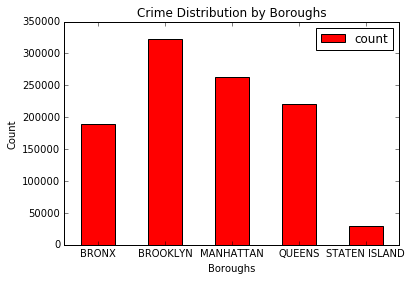

In [23]:
%matplotlib inline

data_borough = data_borough.set_index('Borough')
my_plot = data_borough.plot(kind='bar',title="Crime Distribution by Boroughs",color='red',rot=0)
my_plot.set_xlabel("Boroughs")
my_plot.set_ylabel("Count")

In [24]:

import folium
map_osm= folium.Map(location=[40.730610, -73.935242],zoom_start=12)

for point in rlist:
    folium.Marker( location=[ point[0], point[1] ]).add_to( map_osm )
display(map_osm)


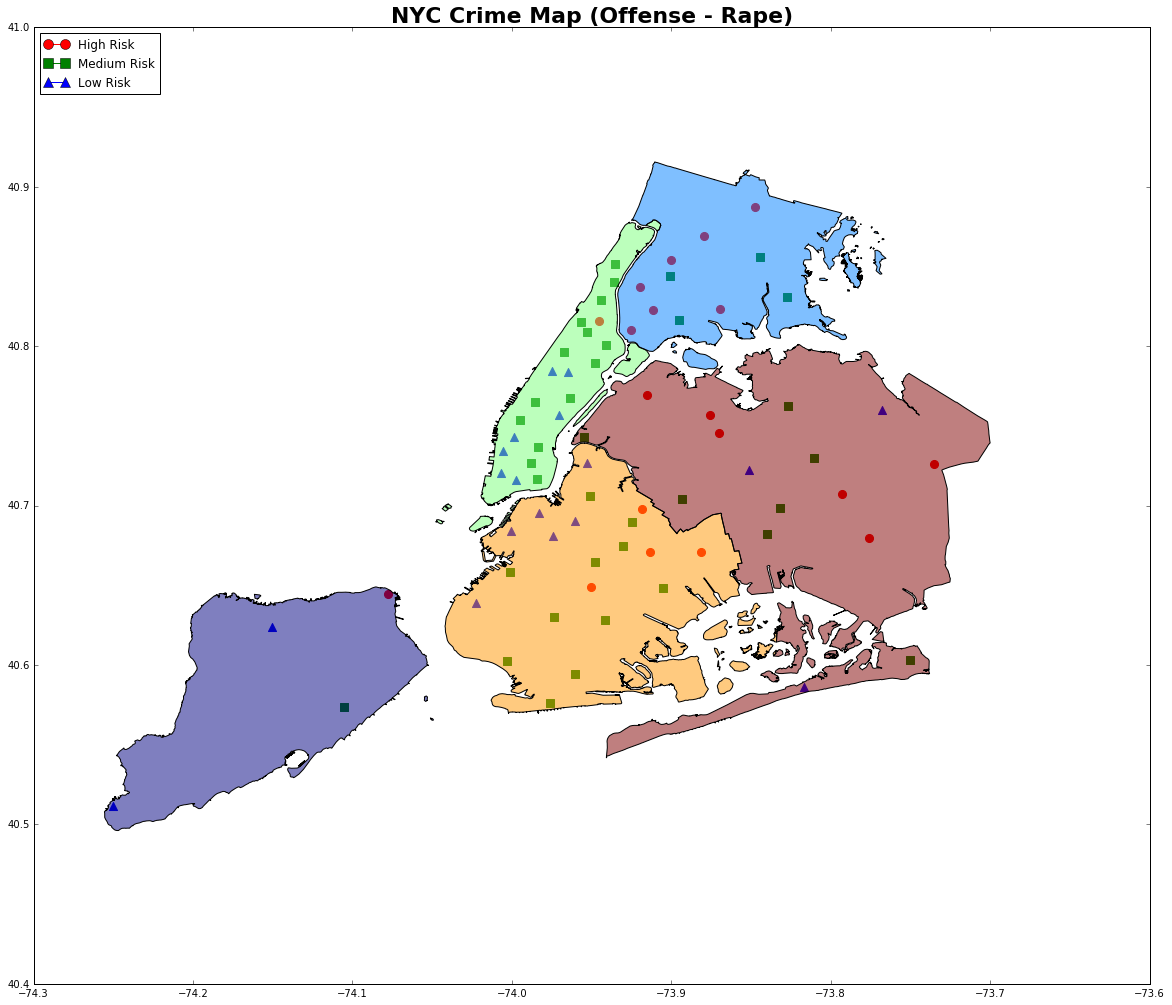

In [25]:
%matplotlib inline

gdf = gpd.GeoDataFrame.from_file('C:\\Users\\Gurpreet\\Documents\\IS602\\borough_shapes')
gdf.plot( figsize=(20,18))
plt.title('NYC Crime Map (Offense - Rape)', fontsize=22, weight= 'bold')
#plt.axis('off')
plt.scatter(data_offense_rape_high['Longitude'],data_offense_rape_high['Latitude'],s=65,marker='o',color='red')

plt.scatter(data_offense_rape_medium['Longitude'],data_offense_rape_medium['Latitude'],s=65,marker='s',color='green')

plt.scatter(data_offense_rape_low['Longitude'],data_offense_rape_low['Latitude'],s=65,marker='^',color='blue')




high=ml.Line2D([],{},color='red',marker='o',markersize=10,label='High Risk')
med=ml.Line2D([],{},color='green',marker='s',markersize=10,label='Medium Risk')
low=ml.Line2D([],{},color='blue',marker='^',markersize=10,label='Low Risk')



plt.legend(handles=[high,med,low],loc='upper left')

### Conclusion:<a id='Conclusion'></a>
This research study was an effort to predict the crime hotspots. This technique is utilized in predictive policing, with more sophisticated tools and teams working together to yield effective results. In random forest regressor, our mean squared error was closely approaching zero, which is good indication in testing the accuracy of prediction algorithms. In this case, the parameters of the model were not tuned in depth.Accurracy with mean squared error closer to zero might be due to overfitting or oob error. However it is not impossible to attain that accuracy in the algorithms.With proper selection and indepth tuning of the algorithms and availability of huge amount of data this accuracy is possible.

#### Further Reading and Analysis:<a id='Further Reading'></a>

* The prediction can be applied to a different target variable. The variable "Sector" selected 
  as a target variable predicted better results. Different variables can be selected for prediction.
  
  
  
* In order to select the best approach, different model can be tested and appplied for prediction.
  Support Vector Machine, Linear Regression, Naive Bayes and Recursive Partitioning are some models that 
  can be considered for the best results.
  
  
  
* Random Forest and other prediction models requires indepth tuning of parameters to yield best results.
  Algorithm tuning assist in overcoming overfitting, out of bag error in splitting training and testing datasets.
  
  
* Using Parallel Computing is another approach which can be considered to speed up the process as the operations on
  the pandas dataframe can be performed faster.

#### Refrences:<a id='Refrences'></a>


.[Machine learning with Python: A Tutorial](https://www.dataquest.io/blog/machine-learning-python/)

.[Python for data science: Getting started](https://www.dataquest.io/blog/python-data-science/)


.[Basic Interactive Geospatial Analysis in Python](http://blog.yhat.com/posts/interactive-geospatial-analysis.html)


.[GeoPandas Documentation](https://media.readthedocs.org/pdf/geopandas/master/geopandas.pdf)


.[Geocoding And Reverse Geocoding](http://chrisalbon.com/python/geocoding_and_reverse_geocoding.html)


.[Python for Data Analysis Part 30: Random Forests](http://hamelg.blogspot.com/2015/12/python-for-data-analysis-part-30-random.html)


.[Machine Learning to predict San Francisco Crime](http://efavdb.com/predicting-san-francisco-crimes/)


.[Diving into data - A blog on machine learning, data mining and visualization](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)

.[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)

.[The Yhat Blog -Random Forests in Python](http://blog.yhat.com/posts/random-forests-in-python.html)